In [1]:
import matplotlib.pyplot as plt
import numpy
import pandas as pd
import torch
import os
import re
import os
import json
import math
from pprint import pprint

In [2]:
logsdir = "results\\storage\\brno2\\home\\bronecja\\peft_unlearning_logs"
data = []

for exp_dir in (f.path for f in os.scandir(logsdir) if f.is_dir()):
    params = [
        (x.split("=")[0], x.split("=")[1])
        for x in re.findall("[a-z]+=[a-zA-Z0-9\.-]+", exp_dir)
    ]
    params[7] = ("lrate", params[7][1])
    params = {x[0]: x[1] for x in params}

    model_results = {}
    for res_dir in (f.path for f in os.scandir(exp_dir) if f.is_dir()):
        with open(res_dir + "/evaluation_results.jsonl") as f:
            results = json.load(f)
            model_results[os.path.basename(res_dir)] = results

    joined = {**params, **model_results}
    data.append(joined)

data[0]

<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Xelf\AppData\Local\Temp\ipykernel_17732\3955151408.py:7: SyntaxWarning: invalid escape sequence '\.'
  for x in re.findall("[a-z]+=[a-zA-Z0-9\.-]+", exp_dir)


{'bs': '4',
 'b': '0.5',
 'd': 'None',
 'e': '20',
 'ee': '-1',
 'ht': 'hf',
 'km': '0.0',
 'lrate': '0.0001',
 'lme': '-1',
 'lr': '5',
 'm': '7B',
 'nm': '1.0',
 'pm': 'lora',
 'rm': '1.0',
 'se': '5',
 'sln': 'True',
 'sm': 'True',
 's': '213345362',
 't': '4',
 'checkpoint_14': {'forget-set': {'overall-regurgitation-score': 0.6188146551687412,
   'overall-knowledge-score': 0.4913294797687861,
   'Task1': {'regurgitation-score': 0.6774337447341127,
    'knowledge-score': 0.5},
   'Task2': {'regurgitation-score': 0.6267164799773495,
    'knowledge-score': 0.43478260869565216},
   'Task3': {'regurgitation-score': 0.5720911222226556,
    'knowledge-score': 0.6764705882352942}},
  'retain-set': {'overall-regurgitation-score': 0.6364108520768172,
   'overall-knowledge-score': 0.544973544973545,
   'Task1': {'regurgitation-score': 0.7523966707968749,
    'knowledge-score': 0.7037037037037037},
   'Task2': {'regurgitation-score': 0.591618219832736,
    'knowledge-score': 0.488},
   'Task3'

In [3]:
ps = [(x["nm"], x["rm"], x["km"]) for x in data]
ps

# compute histogram
hist = {}
for p in ps:
    if p not in hist:
        hist[p] = 0
    hist[p] += 1

print(hist)

{('1.0', '1.0', '0.0'): 5, ('1.0', '1.0', '0.5'): 5, ('1.0', '1.0', '1.0'): 5, ('1.0', '0.0', '1.0'): 5}


In [4]:
scores = {}

for d in data:
    p = (d["rm"], d["km"])
    if p not in scores:
        scores[p] = {}

    c = ["checkpoint_4", "checkpoint_9", "checkpoint_14", "checkpoint_19", "model"]
    for checkpoint in c:
        if checkpoint not in d:
            continue
        if checkpoint not in scores[p]:
            scores[p][checkpoint] = {
                "aggregate": [],
                "harmonic": [],
                "mia": [],
                "mmlu": [],
            }
        scores[p][checkpoint]["aggregate"].append(d[checkpoint]["aggregate-score"])
        scores[p][checkpoint]["harmonic"].append(
            d[checkpoint]["harmonic-mean-task-aggregate"]
        )
        scores[p][checkpoint]["mia"].append(d[checkpoint]["mia_final_score"])
        scores[p][checkpoint]["mmlu"].append(d[checkpoint]["mmlu_average"])

scores

{('1.0',
  '0.0'): {'checkpoint_4': {'aggregate': [0.2984358838827432,
    0.31645550568023023,
    0.24218095448149096,
    0.24667029795271342,
    0.2209173048753486],
   'harmonic': [0,
    0.33723545625479423,
    0.12181766127320891,
    0.23947283818389317,
    0.12440073324954047],
   'mia': [0.41902222222222196,
    0.14417777777777796,
    0.13164444444444445,
    0.02168888888888887,
    0.05964444444444439],
   'mmlu': [0.4762854294260077,
    0.4679532830081185,
    0.47308075772681957,
    0.4788491667853582,
    0.47870673693206095]}, 'checkpoint_9': {'aggregate': [0.6243412502739385,
    0.45360177680577346,
    0.5339912935102876,
    0.38107648660313764,
    0.588420575584061],
   'harmonic': [0.40579613842092277,
    0.44753166569719516,
    0.45823943307956594,
    0.4130679949974994,
    0.4283535053845399],
   'mia': [0.9970666666666668,
    0.4663999999999999,
    0.6795555555555557,
    0.25964444444444457,
    0.8846222222222222],
   'mmlu': [0.4701609457342259

<>:40: SyntaxWarning: invalid escape sequence '\g'
<>:40: SyntaxWarning: invalid escape sequence '\d'
<>:40: SyntaxWarning: invalid escape sequence '\g'
<>:40: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Xelf\AppData\Local\Temp\ipykernel_17732\675338621.py:40: SyntaxWarning: invalid escape sequence '\g'
  label=f"$\gamma$={p[0]}, $\delta$={p[1]}",
C:\Users\Xelf\AppData\Local\Temp\ipykernel_17732\675338621.py:40: SyntaxWarning: invalid escape sequence '\d'
  label=f"$\gamma$={p[0]}, $\delta$={p[1]}",


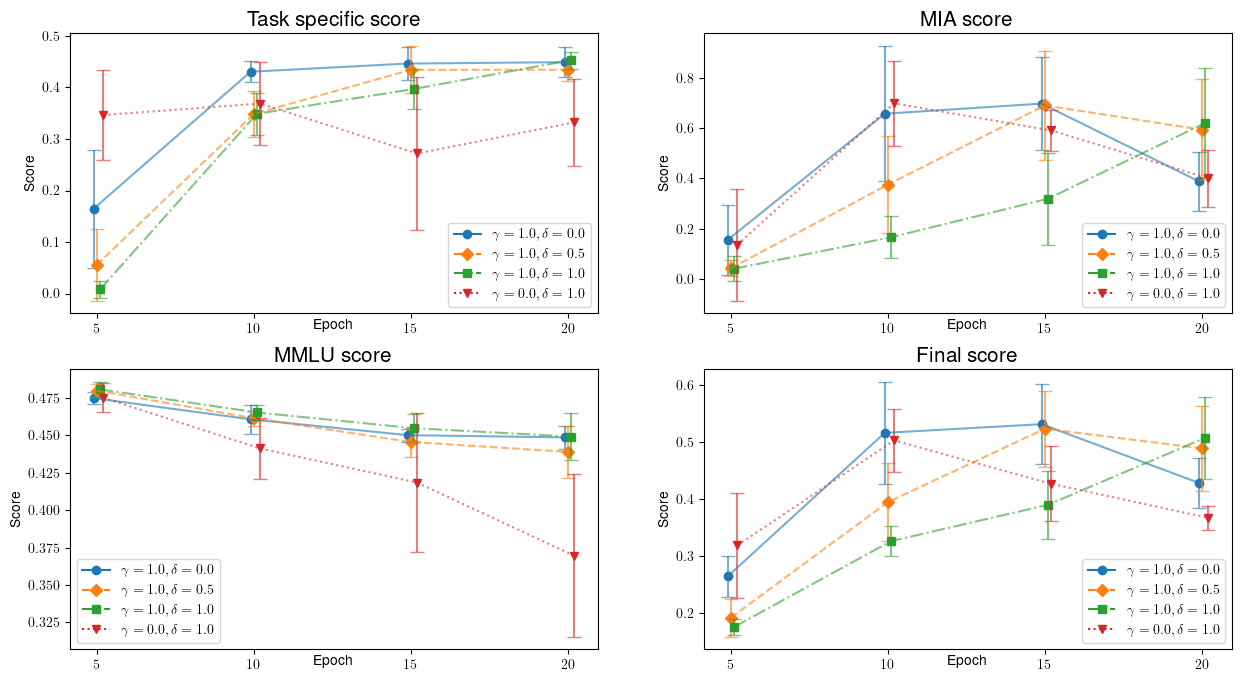

In [28]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

fig, axs = plt.subplots(2, 2, figsize=(15, 8))


points = [
    (5, "checkpoint_4"),
    (10, "checkpoint_9"),
    (15, "checkpoint_14"),
    (20, "checkpoint_19"),
]
measures = ["harmonic", "mia", "mmlu", "aggregate"]
titles = ["Task specific score", "MIA score", "MMLU score", "Final score"]
idx = [(0, 0), (0, 1), (1, 0), (1, 1)]
offsets = [-0.1, 0, 0.1, 0.2]
markers = ["o", "D", "s", "v"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
linestyles = ["-", "--", "-.", ":"]
markersize = 6
linewidth = 1.5

for i, m in enumerate(measures):
    handles = []
    for j, p in enumerate(scores):
        means = []
        stds = []
        for point in points:
            mean = numpy.mean(scores[p][point[1]][m])
            std = numpy.std(scores[p][point[1]][m])
            means.append(mean)
            stds.append(std)

        axs[idx[i]].errorbar(
            [x[0] + offsets[j] for x in points],
            means,
            yerr=stds,
            label=f"$\gamma$={p[0]}, $\delta$={p[1]}",
            alpha=0.6,
            color=colors[j],
            linestyle=linestyles[j],
            linewidth=linewidth,
            capsize=5,
        )
        axs[idx[i]].plot(
            [x[0] + offsets[j] for x in points],
            means,
            marker=markers[j],
            linestyle="None",
            color=colors[j],
            markersize=markersize,
        )
        (legend_handle,) = axs[idx[i]].plot(
            [],
            [],
            marker=markers[j],
            label=f"$\\gamma={p[0]}, \\delta={p[1]}$",
            color=colors[j],
            linestyle=linestyles[j],
            linewidth=linewidth,
        )
        handles.append(legend_handle)
    axs[idx[i]].set_title(titles[i], fontsize=15)
    axs[idx[i]].set_xticks([x[0] for x in points])
    axs[idx[i]].set_xlabel("Epoch", labelpad=-12)
    axs[idx[i]].set_ylabel("Score")
    axs[idx[i]].legend(handles=handles)

#fig.align_labels()
plt.savefig("scores.svg", format="svg", bbox_inches="tight")
plt.show()

In [6]:
# print model means and stds
for p in scores:
    print(f"rm={p[0]}, km={p[1]}")
    for m in measures:
        mean = numpy.mean(scores[p]['model'][m])
        std = numpy.std(scores[p]['model'][m])
        print(f"{m}: {mean} +- {std}")	

rm=1.0, km=0.0
harmonic: 0.452950081313772 +- 0.028260322896620605
mia: 0.38858666666666664 +- 0.11666272467414376
mmlu: 0.4487252528129896 +- 0.007709258397159682
aggregate: 0.43008733359780943 +- 0.043274745648812965
rm=1.0, km=0.5
harmonic: 0.43837502348142304 +- 0.015665013834482905
mia: 0.5936711111111111 +- 0.20190477765398768
mmlu: 0.4390257798034468 +- 0.017274245860379126
aggregate: 0.4903573047986603 +- 0.07326499868207512
rm=1.0, km=1.0
harmonic: 0.4521579703426638 +- 0.01632571886289448
mia: 0.6209244444444445 +- 0.21870096641558565
mmlu: 0.4492664862555191 +- 0.015959428718802928
aggregate: 0.5074496336808758 +- 0.07166664619571456
rm=0.0, km=1.0
harmonic: 0.3295311774639006 +- 0.08751182561942483
mia: 0.4008 +- 0.11382639239182744
mmlu: 0.36971941318900436 +- 0.054240695423429346
aggregate: 0.36668353021763506 +- 0.02196523384979371
